# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
train.isna().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [7]:
train.fillna('', inplace=True)

In [6]:
test.isna().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [9]:
test.fillna('', inplace=True)

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [10]:
train.value_counts(subset = 'target')

target
0    3024
1    2305
dtype: int64

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [42]:
popular_keywords = train.value_counts(subset = 'keyword').head(11).index[1::]

Первый элемент выкинули, т.к. это пустая строка.

<AxesSubplot: xlabel='keyword', ylabel='Count'>

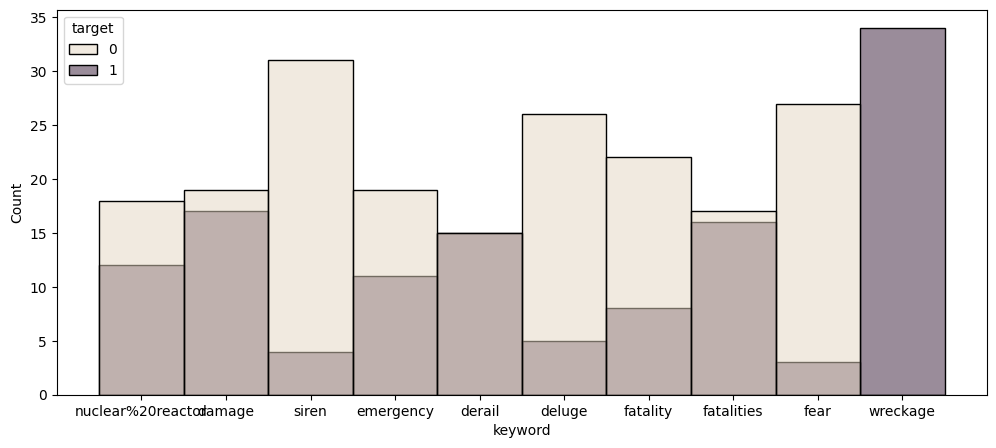

In [56]:
fig, ax = plt.subplots(figsize=(12,5))
sns.histplot(data=train[train.keyword.isin(popular_keywords)], x='keyword', hue='target', palette="ch:.25", ax=ax)

**Выводы**: для большинства из рассматриваемых keyword распределение классов заметно отличается от распределения по всей выборке. Значит признак keyword можно рассматривать как дифференциальный для классификации.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [ ]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [59]:
train.drop('id', axis=1, inplace=True)
train['text'] = train['keyword'] + ' ' + train['location'] + ' ' + train['text']
train.drop(['keyword', 'location'], axis=1, inplace=True)

In [61]:
train.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [62]:
X_train = train['text']
y_train = train['target']

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
train_vec = count_vectorizer.fit_transform(X_train)

In [122]:
train_vec.shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [118]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return any(char.isnumeric() for char in s)

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return any(char in punctuation for char in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s[0] == '@'

def investigate_vocabulary(vocabulary):
    print('With digit:      ', sum([contains_digit(word) for word in vocabulary])
          )
    print('With punctuation:', sum([contains_punctuation(word) for word in vocabulary])
          )
    print('Hashtags:        ', sum([is_hashtag(word) for word in vocabulary])
          )
    print('Mentions:        ', sum([is_mention(word) for word in vocabulary])
          )

In [119]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [123]:
investigate_vocabulary(count_vectorizer.vocabulary_)

With digit:       3815
With punctuation: 315
Hashtags:         0
Mentions:         0


Как видим, CountVectorizer с дефолтным токенайзером не распознает хэштеги и упоминания и плохо работает со словами, содержащими пунктуацию.

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [90]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [124]:
tweet_tokenizer = TweetTokenizer()
count_vectorizer = CountVectorizer(tokenizer=tweet_tokenizer.tokenize)
train_vec = count_vectorizer.fit_transform(X_train)

In [125]:
investigate_vocabulary(count_vectorizer.vocabulary_)

With digit:       3940
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** TweetTokenizer грамотнее работает с дигитальным почерком, характерным для твиттера: распознаёт хэштеги и упоминания, не делит слова с пунктуацией.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [130]:
import nltk
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer(language='english')

In [131]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return all(ord(char) in range(97, 123) for char in s)

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return all(char in punctuation for char in s) and (')' in s or '(' in s)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    s = s.lower()
    tokens = tweet_tokenizer.tokenize(s)
    tokens_cleared = list()
    for token in tokens:
        if is_emoji(token):
            tokens_cleared.append(token)
        elif is_hashtag(token):
            if contains_only_latin_letters(token[1::]):
                tokens_cleared.append(token)
        else:
            if contains_only_latin_letters(token) and token not in nltk.corpus.stopwords.words('english'):
                tokens_cleared.append(token)
    return [snowball_stemmer.stem(word) for word in tokens_cleared]

In [138]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [136]:
X_train.head(10).apply(custom_tokenizer)

1186    [bridg, ash, australia, collaps, trent, bridg,...
4071    [hail, carol, stream, illinoi, great, michigan...
5461    [polic, houston, cnn, tennesse, movi, theater,...
5787        [riot, still, riot, coupl, hour, left, class]
7445    [wound, lake, highland, crack, path, wipe, mor...
151     [airplan, somewher, expert, franc, begin, exam...
915     [bloodi, isol, citi, world, perth, came, kill,...
1305                    [burn, except, idk, realli, burn]
2570                  [destroy, (, ask, ), destroy, hous]
7399    [wound, maracay, nirgua, venezuela, polic, off...
Name: text, dtype: object

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [139]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
train_vec = vectorizer.fit_transform(X_train)

In [141]:
test.drop('id', axis=1, inplace=True)
test['text'] = test['keyword'] + ' ' + test['location'] + ' ' + test['text']
test.drop(['keyword', 'location'], axis=1, inplace=True)

In [142]:
X_test = test['text']
y_test = test['target']

In [143]:
test_vec = vectorizer.transform(X_test)

2. Обучите LogisticRegression на полученных признаках.


In [140]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_vec, y_train)

LogisticRegression()

3. Посчитайте метрику f1-score на тестовых данных.

In [144]:
y_pred = logreg.predict(test_vec)

In [146]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.752953813104189

## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
train_vec = tfidf_vectorizer.fit_transform(X_train)
test_vec = tfidf_vectorizer.transform(X_test)
logreg.fit(train_vec, y_train)
y_pred = logreg.predict(test_vec)
f1_score(y_test, y_pred)

0.7422222222222221

In [151]:
train_vec.shape

(5329, 10482)

1. **Ответ:** качество немного уменьшилось.

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [148]:
# 2
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
train_vec = tfidf_vectorizer.fit_transform(X_train)
test_vec = tfidf_vectorizer.transform(X_test)
logreg.fit(train_vec, y_train)
y_pred = logreg.predict(test_vec)
f1_score(y_test, y_pred)

0.7422222222222221

In [149]:
train_vec.shape

(5329, 10482)

2. **Ответ:** ни размер матрицы, ни результат не изменились.

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [152]:
# 3
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=3)
train_vec = tfidf_vectorizer.fit_transform(X_train)
test_vec = tfidf_vectorizer.transform(X_test)
logreg.fit(train_vec, y_train)
y_pred = logreg.predict(test_vec)
f1_score(y_test, y_pred)

0.744057490326147

In [153]:
train_vec.shape

(5329, 3136)

3. **Ответ:** размер матрицы уменьшился в 3 раза, результат стал немного выше.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [154]:
from sklearn.feature_extraction.text import HashingVectorizer

hashing_vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
train_vec = hashing_vectorizer.fit_transform(X_train)
test_vec = hashing_vectorizer.transform(X_test)
logreg.fit(train_vec, y_train)
y_pred = logreg.predict(test_vec)
f1_score(y_test, y_pred)

c:\users\mozg2\pycharmprojects\py_learning\venv\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7190635451505016

Как видим, качество упало ещё сильнее.

2. Какой из подходов показал самый высокий результат?

2. **Ответ:** самый высокий результат показал CountVectorizer.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [156]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_df=0.5, min_df=5)
train_vec = vectorizer.fit_transform(X_train)
test_vec = vectorizer.transform(X_test)
logreg.fit(train_vec, y_train)
y_pred = logreg.predict(test_vec)
f1_score(y_test, y_pred)

0.752953813104189

CountVectorizer из 8 задания уже показывает результат выше 0.75.

In [158]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=3)
train_vec = vectorizer.fit_transform(X_train)
test_vec = vectorizer.transform(X_test)
logreg.fit(train_vec, y_train)
y_pred = logreg.predict(test_vec)
f1_score(y_test, y_pred)

0.7552222817354044

Но если поиграться с параметрами df, то его можно еще немного улучшить.